In [ ]:
# install packages, set correct path
Load=True #if loading, we do not read from shp files. we read from pickle for speed
path='/content/drive/My Drive/GIS' #Your path
#path='/content/drive/My Drive/Pavement/GIS/' #Egemen Path
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir(path)
import networkx as nx
import pickle
!pip install osmnx
import osmnx as ox

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 931.8 kB/s eta 0:00:00


In [ ]:
# The shortest path is a list of nodes. Create a list of edge tuples from it
#edge_list = [(shortest_path[n], shortest_path[n+1]) for n in range(len(shortest_path)-1)]

# Convert the MultiIndex to a list of tuples, and take only the first two elements of each tuple
#index_tuples = [(a, b) for a, b, _ in edges.index.to_flat_index()]

# Now use this list of tuples to create the shortest_path_edges DataFrame
#shortest_path_edges = edges[np.isin(index_tuples, edge_list)]

def shortest_path_data(shortest_path,edges):
  # Convert the shortest path to a NumPy array
  shortest_path_np = np.array(shortest_path)

  # Create an array of edge pairs
  edge_pairs_np = np.column_stack([shortest_path_np[:-1], shortest_path_np[1:]])

  # Convert the edge pairs array to a list of tuples and add the third index
  edge_list = [(*map(int, edge), 0) for edge in edge_pairs_np]

  # Add the reverse direction for each edge to the list
  edge_list += [(*map(int, edge[::-1]), 0) for edge in edge_pairs_np]

  # Get the edge pairs as a MultiIndex
  edge_pairs_index = pd.MultiIndex.from_tuples(edge_list, names=edges.index.names)

  # Now use this MultiIndex to create the shortest_path_edges DataFrame
  shortest_path_edges = edges[edges.index.isin(edge_pairs_index)]

  return edge_pairs_index,shortest_path_edges

In [ ]:
#LODES=pd.read_pickle('pickle/LODES.pkl')
NodeMatch=pd.read_pickle('pickle/NodeMatch.pkl')
with open('pickle/G.gpickle', 'rb') as f:
  G = pickle.load(f)
nodes=pd.read_pickle('pickle/nodes.pkl')
edges=pd.read_pickle('pickle/edges.pkl')
EJ=pd.read_pickle('pickle/EJ.pkl')
LODES=pd.read_pickle('pickle/LODESMatchNode.pkl')
with open('pickle/unique_trips.pkl', 'rb') as f:
  unique_trips = pickle.load(f)
with open('pickle/tripindex.pkl', 'rb') as f:
  trip_to_indices = pickle.load(f)

# What do we want to store?
1) average PSI and average IRI (upper and lower bound)

2) travel time and travel distance (miles)

3) Fuel consumption (upper and lower bound)


In [ ]:
def returntrip(shortest_trips_paths,shortest_trips_nodes):
  Dict={'LODES_index':[],'EJ':[],'start_node':[],'end_node':[],'length': [], 'time': [],'PSI':[],'Percent_Excellent':[], 'Percent_Good': [],
        'Percent_Fair': [], 'Percent_Poor': [], 'IRI_low': [], 'IRI_high': [], 'E_low': [], 'E_high': [],'fuel_high':[],'fuel_low':[],
        'Percent_fuel_high':[],'Percent_fuel_low':[],'Number_People':[],'Number_EJ':[]}
  Keys=list(Dict.keys())

  # Passenger Car Variables for Fuel Consumption
  p = 3.3753e4
  ka = 6.70e-1
  kc = 2.81e-4
  dc = 2.1860e-1
  da = 2.1757e3
  b = -1.6931e1
  eff = 144.8*1000 #kj/gal

  for i in range(len(shortest_trips_paths)):
      if i%1000==0:
        print(i)

      if shortest_trips_paths[i]=="no path":
        Dict['LODES_index'].append('[]')
        Dict['EJ'].append('')
        Dict['start_node'].append(shortest_trips_nodes[i][0])
        Dict['end_node'].append(shortest_trips_nodes[i][1])
        for k in list(Dict.keys())[4:]: #make all others zero
          Dict[k].append(0)
        continue

      #else we keep going with calculations
      _, dataset = shortest_path_data(shortest_trips_paths[i], edges)

        # Stores length and time
      length = np.sum(dataset['Length'])
      time = np.sum(dataset['time']) / 60
      v = dataset.Speed_Lim

      #calculate percent road excellent, good, fair and poor
      Perc_PSI={'Excellent':0,'Good':0,'Fair':0,'Poor':0}
      A=dataset.groupby(['Condition'])['Length'].sum()/length
      for key in A.keys():
        Perc_PSI[key]=A[key]

        # Finds IRI Values
      current_psi = dataset['PSI']  # Get the current index value of 'PSI'
      IRI_high = 50/9 * np.log(5 / current_psi) * 63.36
      IRI_low = 50/13 * np.log(5 / current_psi) * 63.36
      IRI_high[IRI_high<40]=40;
      IRI_low[IRI_low<40]=40;

        # Fuel Consumption
      E_high_total = np.sum((p/v+(ka * (IRI_high)+da)+b*v + (kc * (IRI_high)+dc) * v**2)*dataset['Length']) #kJ/mile * travel distance
      E_low_total = np.sum((p/v+(ka * (IRI_low)+da)+b*v + (kc * (IRI_low)+dc) * v**2)*dataset['Length']) #kJ/mile * travel distance
      E_base=np.sum((p/v+(ka * (40)+da)+b*v + (kc * (40)+dc) * v**2)*dataset['Length'])

      E_high = np.sum(((ka * (IRI_high-40)) + (kc * (IRI_high-40)) * v**2)*dataset['Length']) #kJ/mile * travel distance
      E_low = np.sum(((ka * (IRI_low-40)) + (kc * (IRI_low-40)) * v**2)*dataset['Length'])
      fuel_high=E_high/eff
      fuel_low=E_low/eff
      perc_high=(E_high_total-E_base)/E_base
      perc_low=(E_low_total-E_base)/E_base

      #find the corresponding S000 from LODES data
      #print(shortest_trips_nodes[localind])
      Number_People = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'S000'].sum()
      LODES_index = str(trip_to_indices[shortest_trips_nodes[i]])

      #search for EJ to see if exists
      # get the index based on the ith trip
      index = trip_to_indices[shortest_trips_nodes[i]]

      # find the h_bg value at this index
      h_bg_value = LODES.loc[index, 'h_bg']

      # subset EJ where GEOID matches the h_bg_value
      subset_EJ = EJ[EJ['GEOID'].isin(h_bg_value[h_bg_value.isin(geoid_set)])]
      lensubset=len(subset_EJ)
      if lensubset>0:
        EJCRIT=subset_EJ.loc[:,['EJ_CRITERI']].values[0][0]
        EJNUM=subset_EJ.loc[:,['EJ_CRITE_1']].values[0][0]
      else:
        EJCRIT=''
        EJNUM=0

        # Creates dictionary
      Dict['start_node'].append(shortest_trips_nodes[i][0])
      Dict['end_node'].append(shortest_trips_nodes[i][1])
      Dict['length'].append(length)
      Dict['time'].append(time)
      Dict['PSI'].append(np.sum(current_psi*dataset['Length'])/np.sum(dataset['Length']))
      Dict['Percent_Excellent'].append(Perc_PSI['Excellent'])
      Dict['Percent_Good'].append(Perc_PSI['Good'])
      Dict['Percent_Fair'].append(Perc_PSI['Fair'])
      Dict['Percent_Poor'].append(Perc_PSI['Poor'])
      Dict['IRI_high'].append(np.sum(IRI_high*dataset['Length'])/np.sum(dataset['Length']))
      Dict['IRI_low'].append(np.sum(IRI_low*dataset['Length'])/np.sum(dataset['Length']))
      Dict['E_high'].append(E_high)
      Dict['E_low'].append(E_low)
      Dict['fuel_high'].append(fuel_high)
      Dict['fuel_low'].append(fuel_low)
      Dict['Percent_fuel_high'].append(perc_high)
      Dict['Percent_fuel_low'].append(perc_low)
      Dict['Number_People'].append(Number_People)
      Dict['LODES_index'].append(LODES_index)
      Dict['EJ'].append(EJCRIT)
      Dict['Number_EJ'].append(EJNUM)

  Frame=pd.DataFrame(Dict)
  return Frame

This one is from https://ascelibrary.org/doi/epdf/10.1061/JPEODX.PVENG-926

In [ ]:
def returntripLiu(shortest_trips_paths,shortest_trips_nodes):
  Dict={'LODES_index':[],'EJ':[],'start_node':[],'end_node':[],'length': [], 'time': [],'PSI':[],'Percent_Excellent':[], 'Percent_Good': [],
        'Percent_Fair': [], 'Percent_Poor': [], 'IRI_low': [], 'IRI_high': [], 'E_low': [], 'E_high': [],'fuel_high':[],'fuel_low':[],
        'Percent_fuel_high':[],'Percent_fuel_low':[],'Number_People':[],'Number_EJ':[]}
  Keys=list(Dict.keys())

  # Passenger Car Variables for Fuel Consumption

  eff = 144.8*1000 #kj/gal

  def fuel_consumption(IRI,v,L):
    ka = -0.5298
    kb = 0.0032
    kc = 1.5548e-4
    kv = 0.3291
    localroughness = 1
    vkph=v*1.609 #to kmph
    IRImkm=IRI*0.0157828
    E=np.sum((ka*IRImkm+kb*IRImkm**2+kc*IRImkm*vkph**2)*(1+kv*localroughness)*L/1.609)
    return E

  for i in range(len(shortest_trips_paths)):
      if i%1000==0:
        print(i)

      if shortest_trips_paths[i]=="no path":
        Dict['LODES_index'].append('[]')
        Dict['EJ'].append('')
        Dict['start_node'].append(shortest_trips_nodes[i][0])
        Dict['end_node'].append(shortest_trips_nodes[i][1])
        for k in list(Dict.keys())[4:]: #make all others zero
          Dict[k].append(0)
        continue

      #else we keep going with calculations
      _, dataset = shortest_path_data(shortest_trips_paths[i], edges)

        # Stores length and time
      length = np.sum(dataset['Length'])
      time = np.sum(dataset['time']) / 60
      v = dataset.Speed_Lim


      #calculate percent road excellent, good, fair and poor
      Perc_PSI={'Excellent':0,'Good':0,'Fair':0,'Poor':0}
      A=dataset.groupby(['Condition'])['Length'].sum()/length
      for key in A.keys():
        Perc_PSI[key]=A[key]

        # Finds IRI Values
      current_psi = dataset['PSI']  # Get the current index value of 'PSI'
      IRI_high = 50/9 * np.log(5 / current_psi) * 63.36
      IRI_low = 50/13 * np.log(5 / current_psi) * 63.36
      IRI_high[IRI_high<40]=40;
      IRI_low[IRI_low<40]=40;

      # Fuel Consumption

      E_high_total = fuel_consumption(IRI_high,v,dataset['Length']) #kJ/mile * travel distance
      E_low_total = fuel_consumption(IRI_low,v,dataset['Length']) #kJ/mile * travel distance
      E_base=fuel_consumption(40,v,dataset['Length'])

      E_high = E_high_total-E_base #kJ/mile * travel distance
      E_low = E_low_total-E_base
      fuel_high=E_high/eff
      fuel_low=E_low/eff
      perc_high=(E_high_total-E_base)/E_base
      perc_low=(E_low_total-E_base)/E_base

      #find the corresponding S000 from LODES data
      #print(shortest_trips_nodes[localind])
      Number_People = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'S000'].sum()
      LODES_index = str(trip_to_indices[shortest_trips_nodes[i]])

      #search for EJ to see if exists
      # get the index based on the ith trip
      index = trip_to_indices[shortest_trips_nodes[i]]

      # find the h_bg value at this index
      h_bg_value = LODES.loc[index, 'h_bg']

      # subset EJ where GEOID matches the h_bg_value
      subset_EJ = EJ[EJ['GEOID'].isin(h_bg_value[h_bg_value.isin(geoid_set)])]
      lensubset=len(subset_EJ)
      if lensubset>0:
        EJCRIT=subset_EJ.loc[:,['EJ_CRITERI']].values[0][0]
        EJNUM=subset_EJ.loc[:,['EJ_CRITE_1']].values[0][0]
      else:
        EJCRIT=''
        EJNUM=0

        # Creates dictionary
      Dict['start_node'].append(shortest_trips_nodes[i][0])
      Dict['end_node'].append(shortest_trips_nodes[i][1])
      Dict['length'].append(length)
      Dict['time'].append(time)
      Dict['PSI'].append(np.sum(current_psi*dataset['Length'])/np.sum(dataset['Length']))
      Dict['Percent_Excellent'].append(Perc_PSI['Excellent'])
      Dict['Percent_Good'].append(Perc_PSI['Good'])
      Dict['Percent_Fair'].append(Perc_PSI['Fair'])
      Dict['Percent_Poor'].append(Perc_PSI['Poor'])
      Dict['IRI_high'].append(np.sum(IRI_high*dataset['Length'])/np.sum(dataset['Length']))
      Dict['IRI_low'].append(np.sum(IRI_low*dataset['Length'])/np.sum(dataset['Length']))
      Dict['E_high'].append(E_high)
      Dict['E_low'].append(E_low)
      Dict['fuel_high'].append(fuel_high)
      Dict['fuel_low'].append(fuel_low)
      Dict['Percent_fuel_high'].append(perc_high)
      Dict['Percent_fuel_low'].append(perc_low)
      Dict['Number_People'].append(Number_People)
      Dict['LODES_index'].append(LODES_index)
      Dict['EJ'].append(EJCRIT)
      Dict['Number_EJ'].append(EJNUM)

  Frame=pd.DataFrame(Dict)
  return Frame

Reading all possible chunks of data and looping to read them all

In [ ]:
#Format GEOID as integer
EJ.GEOID=EJ.GEOID.astype(str).astype(int)

#for easier EJ search, we convert it into a set
geoid_set = set(EJ['GEOID'])

# Specify your directory here
directory = 'paths/chunks3'

# Get a list of all files in the directory
files = os.listdir(directory)

# Filter the list for files that start with 'path_' and are not directories
matching_files = [f for f in files if f.startswith('path_') and os.path.isfile(os.path.join(directory, f))]
matching_files=len(matching_files)

for idx in range(matching_files):
  pathtrip='paths/chunks3/path_'+str(idx)+'.pkl'
  pathnode='paths/chunks3/nodes_'+str(idx)+'.pkl'
  pathsave='trips/trip_'+str(idx)+'.pkl'
  with open(pathtrip, 'rb') as f:
      shortest_trips_paths = pickle.load(f)
  with open(pathnode, 'rb') as f:
      shortest_trips_nodes = pickle.load(f)
  print('started trip '+str(idx))
  Frame=returntrip(shortest_trips_paths[:100],shortest_trips_nodes)
  #Frame.to_pickle(pathsave) #just preventing from saving as this step is done

started trip 0


NameError: ignored

Once it is built, we can build a larger dataframe from all of them

In [ ]:
# Directory where your files are
folder_path = 'trips/'

# Get list of all pickle files
files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]

# Sort the files so they're in order
files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # splits by '_' and '.' to get the integer

# Initialize an empty dataframe
all_data = pd.DataFrame()

# Loop through all files
for file in files:
    # Create the complete file path
    file_path = os.path.join(folder_path, file)

    # Load dataframe from pickle file
    df = pd.read_pickle(file_path)

    # Concatenate the loaded dataframe with the main dataframe
    all_data = pd.concat([all_data, df], ignore_index=True)
    print(file)

# Now all_data contains all the data from all pickled dataframes
all_data.to_pickle('pickle/TripSummary.pkl')
all_data.to_csv('TripSummary.csv',index=False)

trip_0.pkl
trip_1.pkl
trip_2.pkl
trip_3.pkl
trip_4.pkl
trip_5.pkl
trip_6.pkl
trip_7.pkl
trip_8.pkl
trip_9.pkl
trip_10.pkl
trip_11.pkl
trip_12.pkl
trip_13.pkl
trip_14.pkl
trip_15.pkl
trip_16.pkl
trip_17.pkl
trip_18.pkl
trip_19.pkl
trip_20.pkl
trip_21.pkl
trip_22.pkl
trip_23.pkl
trip_24.pkl
trip_25.pkl
trip_26.pkl
trip_27.pkl
trip_28.pkl
trip_29.pkl
trip_30.pkl
trip_31.pkl
trip_32.pkl
trip_33.pkl
trip_34.pkl
trip_35.pkl
trip_36.pkl
trip_37.pkl
trip_38.pkl
trip_39.pkl
trip_40.pkl
trip_41.pkl
trip_42.pkl
trip_43.pkl
trip_44.pkl
trip_45.pkl
trip_46.pkl
trip_47.pkl
trip_48.pkl
trip_49.pkl
trip_50.pkl
trip_51.pkl
trip_52.pkl
trip_53.pkl
trip_54.pkl
trip_55.pkl
trip_56.pkl
trip_57.pkl
trip_58.pkl
trip_59.pkl
trip_60.pkl
trip_61.pkl
trip_62.pkl
trip_63.pkl
trip_64.pkl
trip_65.pkl
trip_66.pkl
trip_67.pkl
trip_68.pkl
trip_69.pkl
trip_70.pkl
trip_71.pkl
trip_72.pkl
trip_73.pkl
trip_74.pkl
trip_75.pkl
trip_76.pkl
trip_77.pkl
trip_78.pkl
trip_79.pkl
trip_80.pkl
trip_81.pkl
trip_82.pkl
trip_83.pkl
tr

# Questions we want to be answered

1) For EJ and Non-EJ communities, what do their trips look like?
- Do they travel similar distances?
- Do they travel similar times?
- What are the road conditions that they travel on (excellent, good etc)
- Same question above but for IRI bounds
- Same question for percent increase in energy consumption
- More questions?

2) For a few select cases visualizing what their trips and road condition look us

3) Overall documentation and writing

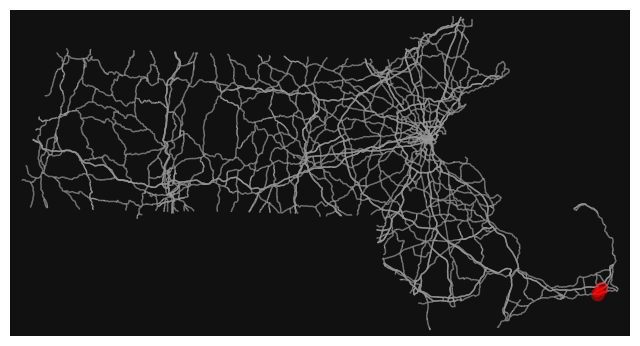

In [ ]:
shortest_trips_nodes[0]
# plot the route with nodes invisible
fig, ax = ox.plot_graph_route(G, shortest_trips_paths[3500], node_size=0) #9900
plt.show()

MARK PATTERN TESTING

In [ ]:
def returntripPattern(shortest_trips_paths,shortest_trips_nodes):
  Dict={'LODES_index':[],'EJ':[],'start_node':[],'end_node':[],'length': [], 'time': [],'PSI':[],'Percent_Excellent':[], 'Percent_Good': [],
        'Percent_Fair': [], 'Percent_Poor': [], 'IRI_low': [], 'IRI_high': [], 'E_low': [], 'E_high': [],'fuel_high':[],'fuel_low':[],
        'Percent_fuel_high':[],'Percent_fuel_low':[],'Number_People':[],'Number_EJ':[],'SA01':[],'SA02':[],'SA03':[],'SE01':[],'SE02':[],'SE03':[],'SI01':[],'SI02':[],'SI03':[]}
  Keys=list(Dict.keys())

  # Passenger Car Variables for Fuel Consumption

  eff = 144.8*1000 #kj/gal

  def fuel_consumption(IRI,v,L):
    ka = -0.5298
    kb = 0.0032
    kc = 1.5548e-4
    kv = 0.3291
    localroughness = 1
    vkph=v*1.609 #to kmph
    IRImkm=IRI*0.0157828
    E=np.sum((ka*IRImkm+kb*IRImkm**2+kc*IRImkm*vkph**2)*(1+kv*localroughness)*L/1.609)
    return E

  for i in range(len(shortest_trips_paths)):
      if i%1000==0:
        print(i)

      if shortest_trips_paths[i]=="no path":
        Dict['LODES_index'].append('[]')
        Dict['EJ'].append('')
        Dict['start_node'].append(shortest_trips_nodes[i][0])
        Dict['end_node'].append(shortest_trips_nodes[i][1])
        for k in list(Dict.keys())[4:]: #make all others zero
          Dict[k].append(0)
        continue

      #else we keep going with calculations
      _, dataset = shortest_path_data(shortest_trips_paths[i], edges)

        # Stores length and time
      length = np.sum(dataset['Length'])
      time = np.sum(dataset['time']) / 60
      v = dataset.Speed_Lim


      #calculate percent road excellent, good, fair and poor
      Perc_PSI={'Excellent':0,'Good':0,'Fair':0,'Poor':0}
      A=dataset.groupby(['Condition'])['Length'].sum()/length
      for key in A.keys():
        Perc_PSI[key]=A[key]

      # Finds IRI Values
      current_psi = dataset['PSI']  # Get the current index value of 'PSI'
      IRI_high = 50/9 * np.log(5 / current_psi) * 63.36
      IRI_low = 50/13 * np.log(5 / current_psi) * 63.36
      IRI_high[IRI_high<40]=40;
      IRI_low[IRI_low<40]=40;

      # Fuel Consumption
      E_high_total = fuel_consumption(IRI_high,v,dataset['Length']) #kJ/mile * travel distance
      E_low_total = fuel_consumption(IRI_low,v,dataset['Length']) #kJ/mile * travel distance
      E_base = fuel_consumption(40,v,dataset['Length'])

      E_high = E_high_total-E_base #kJ/mile * travel distance
      E_low = E_low_total-E_base
      fuel_high = E_high/eff
      fuel_low = E_low/eff
      perc_high = (E_high_total-E_base)/E_base
      perc_low = (E_low_total-E_base)/E_base

      #find the corresponding LODES data
      Number_People = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'S000'].sum()
      LODES_index = str(trip_to_indices[shortest_trips_nodes[i]])
      SA01 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SA01'].sum()
      SA02 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SA02'].sum()
      SA03 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SA03'].sum()
      SE01 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SE01'].sum()
      SE02 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SE02'].sum()
      SE03 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SE03'].sum()
      SI01 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SI01'].sum()
      SI02 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SI02'].sum()
      SI03 = LODES.loc[trip_to_indices[shortest_trips_nodes[i]],'SI03'].sum()

      #search for EJ to see if exists
      # get the index based on the ith trip
      index = trip_to_indices[shortest_trips_nodes[i]]

      # find the h_bg value at this index
      h_bg_value = LODES.loc[index, 'h_bg']

      # subset EJ where GEOID matches the h_bg_value
      subset_EJ = EJ[EJ['GEOID'].isin(h_bg_value[h_bg_value.isin(geoid_set)])]
      lensubset=len(subset_EJ)
      if lensubset>0:
        EJCRIT=subset_EJ.loc[:,['EJ_CRITERI']].values[0][0]
        EJNUM=subset_EJ.loc[:,['EJ_CRITE_1']].values[0][0]
      else:
        EJCRIT=''
        EJNUM=0

        # Creates dictionary
      Dict['start_node'].append(shortest_trips_nodes[i][0])
      Dict['end_node'].append(shortest_trips_nodes[i][1])
      Dict['length'].append(length)
      Dict['time'].append(time)
      Dict['PSI'].append(np.sum(current_psi*dataset['Length'])/np.sum(dataset['Length']))
      Dict['Percent_Excellent'].append(Perc_PSI['Excellent'])
      Dict['Percent_Good'].append(Perc_PSI['Good'])
      Dict['Percent_Fair'].append(Perc_PSI['Fair'])
      Dict['Percent_Poor'].append(Perc_PSI['Poor'])
      Dict['IRI_high'].append(np.sum(IRI_high*dataset['Length'])/np.sum(dataset['Length']))
      Dict['IRI_low'].append(np.sum(IRI_low*dataset['Length'])/np.sum(dataset['Length']))
      Dict['E_high'].append(E_high)
      Dict['E_low'].append(E_low)
      Dict['fuel_high'].append(fuel_high)
      Dict['fuel_low'].append(fuel_low)
      Dict['Percent_fuel_high'].append(perc_high)
      Dict['Percent_fuel_low'].append(perc_low)
      Dict['Number_People'].append(Number_People)
      Dict['LODES_index'].append(LODES_index)
      Dict['EJ'].append(EJCRIT)
      Dict['Number_EJ'].append(EJNUM)
      Dict['SA01'].append(SA01)
      Dict['SA02'].append(SA02)
      Dict['SA03'].append(SA03)
      Dict['SE01'].append(SE01)
      Dict['SE02'].append(SE02)
      Dict['SE03'].append(SE03)
      Dict['SI01'].append(SI01)
      Dict['SI02'].append(SI02)
      Dict['SI03'].append(SI03)

  Frame=pd.DataFrame(Dict)
  return Frame

In [ ]:
#Format GEOID as integer
EJ.GEOID=EJ.GEOID.astype(str).astype(int)

#for easier EJ search, we convert it into a set
geoid_set = set(EJ['GEOID'])

# Specify your directory here
directory = 'paths/chunks3'

# Get a list of all files in the directory
files = os.listdir(directory)

# Filter the list for files that start with 'path_' and are not directories
matching_files = [f for f in files if f.startswith('path_') and os.path.isfile(os.path.join(directory, f))]
matching_files=len(matching_files)

for idx in range(matching_files):
  pathtrip='paths/chunks3/path_'+str(idx)+'.pkl'
  pathnode='paths/chunks3/nodes_'+str(idx)+'.pkl'
  pathsave='patterns/trip_'+str(idx)+'.pkl'
  with open(pathtrip, 'rb') as f:
      shortest_trips_paths = pickle.load(f)
  with open(pathnode, 'rb') as f:
      shortest_trips_nodes = pickle.load(f)
  print('started trip '+str(idx))
  Frame=returntripPattern(shortest_trips_paths[:100],shortest_trips_nodes)
  Frame.to_pickle(pathsave) #just preventing from saving as this step is done

started trip 0
0
started trip 1
0
started trip 2
0


KeyboardInterrupt: ignored

In [ ]:
# Directory where your files are
folder_path = 'patterns/'

# Get list of all pickle files
files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]

# Sort the files so they're in order
files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # splits by '_' and '.' to get the integer

# Initialize an empty dataframe
all_data = pd.DataFrame()

# Loop through all files
for file in files:
    # Create the complete file path
    file_path = os.path.join(folder_path, file)

    # Load dataframe from pickle file
    df = pd.read_pickle(file_path)

    # Concatenate the loaded dataframe with the main dataframe
    all_data = pd.concat([all_data, df], ignore_index=True)
    print(file)

# Now all_data contains all the data from all pickled dataframes
all_data.to_pickle('TripSummaryPattern.pkl')
all_data.to_csv('TripSummaryPattern.csv',index=False)

trip_0.pkl
trip_1.pkl
trip_2.pkl
trip_3.pkl
trip_4.pkl
trip_5.pkl
trip_6.pkl
trip_7.pkl
trip_8.pkl
trip_9.pkl
trip_10.pkl
trip_11.pkl
trip_12.pkl
trip_13.pkl
trip_14.pkl
trip_15.pkl
trip_16.pkl
trip_17.pkl
trip_18.pkl
trip_19.pkl
trip_20.pkl
trip_21.pkl
trip_22.pkl
trip_23.pkl
trip_24.pkl
trip_25.pkl
trip_26.pkl
trip_27.pkl
trip_28.pkl
trip_29.pkl
trip_30.pkl
trip_31.pkl
trip_32.pkl
trip_33.pkl
trip_34.pkl
trip_35.pkl
trip_36.pkl
trip_37.pkl
trip_38.pkl
trip_39.pkl
trip_40.pkl
trip_41.pkl
trip_42.pkl
trip_43.pkl
trip_44.pkl
trip_45.pkl
trip_46.pkl
trip_47.pkl
trip_48.pkl
trip_49.pkl
trip_50.pkl
trip_51.pkl
trip_52.pkl
trip_53.pkl
trip_54.pkl
trip_55.pkl
trip_56.pkl
trip_57.pkl
trip_58.pkl
trip_59.pkl
trip_60.pkl
trip_61.pkl
trip_62.pkl
trip_63.pkl
trip_64.pkl
trip_65.pkl
trip_66.pkl
trip_67.pkl
trip_68.pkl
trip_69.pkl
trip_70.pkl
trip_71.pkl
trip_72.pkl
trip_73.pkl
trip_74.pkl
trip_75.pkl
trip_76.pkl
trip_77.pkl
trip_78.pkl
trip_79.pkl
trip_80.pkl
trip_81.pkl
trip_82.pkl
trip_83.pkl
tr